### Reinforcement learning - Final project demo notebook
#### Nir Weingarten - ID 302528435

In [1]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
!pip install gym[box2d]
!pip install gym_sokoban

zsh:1: command not found: apt-get
Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-11.jdk/Contents/Home/bin/apt" (-1)


/Users/nirweingarten/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nirweingarten/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nirweingarten/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

zsh:1: no matches found: gym[box2d]


In [2]:
import os
os.chdir('..')
import time
import pandas as pd
from a2c_agent import *
from dqn_agent import *
import pickle
from models import *
import utils

In [3]:
def find_best(model_type, agent_type, num_iterations, pkl_save_path, epochs,
              action_type, no_per=False, epsilon=0, epsilon_decay=0.997):
    agent_list = []
    for i in range(num_iterations):
        envs = [utils.EnvWrapper('LunarLanderContinuous-v2', utils.ObsType['BOX2D'], 
                                                    utils.ActionType[action_type], 
                                                    5000, num_discrete=NUM_DISCRETE,
                                                    clip_gradient=CLIP_GRADIENT,
                                                    cone_trick=CONE_TRICK,
                                                    move_trick=False,
                                                    trick_fine=TRICK_FINE) for _ in range(2)]
        env_gen = utils.AsyncEnvGen(envs, 1)
        model = model_type(envs[0].obs_size, envs[0].num_actions, 
                                                hidden_size=HIDDEN_SIZE,
                                                num_discrete=NUM_DISCRETE,
                                                std_bias=5)
        agent = agent_type(model, MODEL_SAVE_PATH, LOG_PATH)
        print('#'*20, 'Attempt {} '.format(i), '#'*20)    
        start = time.time()
        try:
            agent.train(epochs=epochs,
                        trajectory_len=TRAJ_LEN,
                        env_gen=env_gen,
                        lr=LR,
                        discount_gamma=DISCOUNT,
                        scheduler_gamma=SCHED_GAMMA,
                        beta=BETA,
                        print_interval=PRINT_INTERVAL,
                        log_interval=LOG_INTERVAL,
                        scheduler_interval=SCHED_INTERVAL,
                        stop_trick_at=STOP_TRICK_AT,
                        no_cuda=NO_CUDA,
                        no_per=no_per,
                        epsilon=epsilon,
                        epsilon_decay=epsilon_decay)
        except Exception as e:
            raise e
        finally:
            end = time.time()
            utils.kill_process(env_gen)
            agent_list.append(agent)
        print('----- training took {:.3f} minutes -----\n'.format((end - start)/60))

    with open(pkl_save_path, 'wb') as f:
        pickle.dump(agent_list, f)
    return agent_list            

In [4]:
BETA = 1e-3
PRINT_INTERVAL = 100
LOG_INTERVAL = 0
SCHED_GAMMA = 0.75
SCHED_INTERVAL = 400
NO_CUDA = False
MODEL_NAME = 'SimpleDQN'
DISCOUNT = 0.99
TRAJ_LEN = 1500
TRICK_FINE = 100
MODEL_SAVE_PATH = './saved_agents/model.pkl'
LOG_PATH = './log.log'
DRIVE_PATH = './saved_agents'
CLIP_GRADIENT = False
STOP_TRICK_AT = 500

In [5]:
num_iterations = 2
CONE_TRICK = True
NUM_DISCRETE = 13
LR = 0.005
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 500
pkl_save_path = os.path.join(DRIVE_PATH, 'test.pkl')
a2c_per_agent = find_best(DiscreteActorCritic, A2CAgent, num_iterations, pkl_save_path, epochs=1,
                           action_type='DISCRETIZIED', no_per=False)

#################### Attempt 0  ####################
Using CPU
---------- Finished training ----------
Killed env gen process
Saved agent to ./saved_agents/model.pkl
----- training took 0.003 minutes -----

#################### Attempt 1  ####################
Using CPU
---------- Finished training ----------
Killed env gen process
Saved agent to ./saved_agents/model.pkl
----- training took 0.003 minutes -----



In [10]:
num_iterations = 1
CONE_TRICK = False
NUM_DISCRETE = 13
LR = 0.001
HIDDEN_SIZE = 256
CLIP_GRADIENT = False
STOP_TRICK_AT = 200
pkl_save_path = os.path.join(DRIVE_PATH, 'best_dqn.pkl')
dqn_per_agent = find_best(SimpleDQN, DQNAgent, num_iterations, pkl_save_path, epochs=1,
                           action_type='FIXED_LUNAR', no_per=False)

#################### Attempt 0  ####################
Using CPU
---------- Finished training ----------
Killed env gen process
Saved agent to ./saved_agents/model.pkl
----- training took 0.004 minutes -----



In [11]:
agent = dqn_per_agent[0]

In [6]:
def moving_average(iterable, window):
    averages = []
    for i in range(1, len(iterable)):
        averages.append(np.mean(iterable[max(0, i-window):i]))
    return averages


def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [7]:
agent = a2c_per_agent[0]

In [12]:

all_rewards, all_episode_rewards = utils.evaluate(agent, num_episodes=5, render=False)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [9]:
# all_rewards
all_episode_rewards

[-9.071023334139957,
 -14.158846790246264,
 -12.142196743932292,
 -14.075400300752795,
 -11.583521831249822]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7,7))
axes[0].plot(all_rewards)
axes[0].plot(moving_average(all_rewards, window=100))
axes[0].set_title('Rewards per step')
axes[1].plot(all_episode_rewards)
axes[1].plot(moving_average(all_episode_rewards, window=100))
axes[1].set_title('Rewards per episode')

In [ ]:
ipythondisplay.display(HTML(data="""<video alt=\"test\" autoplay loop controls style=\"height: 400px;\"><source src=\"data:video/mp4;base64,{0}\" type=\"video/mp4\" /></video>""".format(encoded.decode('ascii'))))


ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))

> /Users/nirweingarten/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/gym/wrappers/monitoring/stats_recorder.py(48)before_step()
     46             raise error.ResetNeeded("Trying to step environment which is currently done. While the monitor is active for {}, you cannot step beyond the end of an episode. Call 'env.reset()' to start the next episode.".format(self.env_id))
     47         elif self.steps is None:
---> 48             raise error.ResetNeeded("Trying to step an environment before reset. While the monitor is active for {}, you must call 'env.reset()' before taking an initial step.".format(self.env_id))
     49 
     50     def after_step(self, observation, reward, done, info):

ipdb> u
> /Users/nirweingarten/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/gym/wrappers/monitor.py(157)_before_step()
    155     def _before_step(self, action):
    156         if not self.enabled: return
--> 157         self.stats_recorder.before_step(action)
    158 


ipdb> episode
*** NameError: name 'episode' is not defined


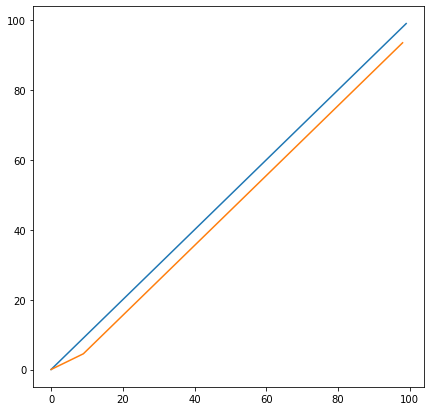

In [34]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,1, figsize=(7,7))
axes.plot(np.arange(0,100))
axes.plot(utils.moving_average(np.arange(0,100), 10))

In [16]:
%debug

> /Users/nirweingarten/Desktop/university/idc/2.2021/rl/project/git/utils.py(232)evaluate()
    230             fig, axes = plt.subplots(1, 2, figsize=(7,7))
    231             axes[0].plot(all_rewards)
--> 232             axes[0].plot(moving_average(all_rewards, window=100))
    233             axes[0].set_title('Rewards per step')
    234             axes[1].plot(all_episode_rewards)

ipdb> moving_average(all_rewards, window=100)
[nan]
ipdb> all_rewards
[-100]
ipdb> moving_average([1,2,3,4,5,6], window=100)
[nan, 1.0, 1.5, 2.0, 2.5, 3.0]
ipdb> exit


### Lunar Lander - training
Hyperparameters we're tuned seperatly for all settings

#### A2C setting 1
Action space is 13 discretiaztions (per axis) automatically generated 

#### A2C setting 2
Action space is 8 pre-made (8 overall) actions

#### A2C setting 3
In this setting we've used a gaussian action space (output is $(\mu_1,\sigma_1),(\mu_2,\sigma_2)$)

#### A2C setting 4
In this setting we've used 1D convolutional layers for feature extraction

#### A2C setting 5
Same as setting 1 only using a training trick called 'the cone trick'

#### DQN setting 1
Epsilon soft + PER

#### DQN setting 2
Epsilon soft + no PER

#### DQN setting 3
Epsilon greedy + PER

#### DQN setting 4
Epsilon greedy + no PER

#### DQN setting 5
Same as setting 1 only using the 'cone trick'

### Lunar Lander - visualization

### Sokoban - visualization
Sokoban was trained in a different notebook over the course of 3 days.
Different settings and models were used, finally I've decided on the model that yielded the best results on LunarLander 

In [ ]:
BETA = 1e-3
PRINT_INTERVAL = 100
LOG_INTERVAL = 0
SCHED_GAMMA = 0.75
SCHED_INTERVAL = 400
NO_CUDA = False
MODEL_NAME = 'SimpleDQN'
DISCOUNT = 0.99
TRAJ_LEN = 1500
TRICK_FINE = 100
MODEL_SAVE_PATH = './model.pkl'
LOG_PATH = './log.log'
DRIVE_PATH = './saved_agents'
CLIP_GRADIENT = False
STOP_TRICK_AT = 500